In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from sklearn.datasets import load_iris,load_diabetes
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import *

In [31]:
dogs_train = pd.read_csv('dogs_train.csv')
calm_X = dogs_train[["Age (months)", "Calm/Relaxed"]].to_numpy()
ener_X = dogs_train[["Age (months)", "Energetic/Enthusiastic"]].to_numpy()
y_train = dogs_train['BreedGroupId'].to_numpy()

X_train = ener_X
y = y_train

In [32]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
train_ds = TensorDataset(X_train, y_train)

batch_size = 20
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)

In [33]:
n_samples, n_features = X_train.shape
n_hidden = 6 # Creating 3 neurons here
n_hidden2 = 3
lr = 0.05
n_epoch = 500

In [34]:
class mlp(torch.nn.Module):

    def __init__(self, num_features, n_hidden, n_hidden2, num_classes):
        super(mlp, self).__init__() # Superconstructor
        self.linear1 = torch.nn.Linear(num_features, n_hidden) # 1st linear part
        self.relu1=nn.ReLU() # Activation function
        self.linear2=torch.nn.Linear(n_hidden, n_hidden2) # 2nd linear part
        self.relu2=nn.ReLU() # Activation function
        self.linear3=torch.nn.Linear(n_hidden2, num_classes) # 2nd linear part
    
    def forward(self, x):
        out = self.linear1(x) # 1st linear to output
        out=self.relu1(out) # Activation function to output
        out=self.linear2(out) # 2nd linear to output
        out=self.relu2(out) # Activation function to output
        out=self.linear3(out) # 2nd linear to output
        return out

model2 = mlp(num_features = n_features, n_hidden = n_hidden, n_hidden2 = n_hidden2, num_classes=4)
optimizer = torch.optim.SGD(model2.parameters(), lr = lr)
lossfunc = nn.CrossEntropyLoss()

In [35]:
for epoch in range(n_epoch):
    model2.train()
    for x_batch, y_batch in train_dl:
        #### Compute outputs ####
        probas = model2(x_batch)
        
        #### Compute gradients ####
        loss = lossfunc(probas, y_batch.long())
        optimizer.zero_grad()
        loss.backward()

        #### Update weights ####  
        optimizer.step()
   
    if (epoch) % 100 == 99:
        model2.eval()
        with torch.inference_mode():
            # Compute the model's predictions 
            outputs = nn.functional.softmax(model2(X_train) , dim=1)
            _, predicted = torch.max(outputs, 1) 
        
            # Compute the accuracy 
            acc = (predicted == y_train).float().mean().item() * 100
            print(f"Epoch {epoch}, Loss={loss.item():.4f}, Test Accuracy={acc:.2f}%")

Epoch 99, Loss=1.5901, Test Accuracy=34.35%
Epoch 199, Loss=1.1809, Test Accuracy=34.35%
Epoch 299, Loss=1.6017, Test Accuracy=34.42%
Epoch 399, Loss=1.3689, Test Accuracy=34.38%
Epoch 499, Loss=1.2022, Test Accuracy=34.35%


In [36]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary_torch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', '^', 'o', 'x', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

C:\Users\sisik\AppData\Local\Temp\ipykernel_50192\2572651660.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
C:\Users\sisik\AppData\Local\Temp\ipykernel_50192\2572651660.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(x2_min, x2_max, resolution))
C:\Users\sisik\AppData\Local\Temp\ipykernel_50192\2572651660.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


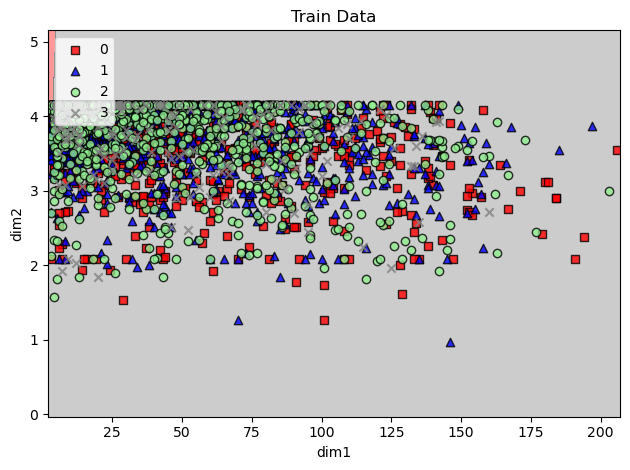

In [37]:
plot_decision_boundary_torch(X_train, y_train, classifier=model2)
plt.title("Train Data")
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()